In [3]:
!pip install torchmetrics

# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import torch
import torchvision

from mlxtend.plotting import plot_confusion_matrix
from PIL import Image
from timeit import default_timer as timer
from torch import nn
from torchmetrics.classification import(
    MulticlassAccuracy,
    MulticlassConfusionMatrix,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassRecall
)
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
from typing import Tuple, Dict, List

# for copying data from gdrive
from google.colab import drive
drive.mount('/content/drive')

#adjust paths based on location of data in drive
drive_path = '/content/drive/MyDrive/Podge_combi/Podge_3g_combi_2200/Podge_1g_combi_3000'
content_path = '/content/Podge_1g_combi_3000/'
!cp -r "{drive_path}" /content/
%cd "{content_path}"
!unzip posters

# use cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"

Streaming output truncated to the last 5000 lines.
  inflating: posters/240202.jpg      
  inflating: posters/67261.jpg       
  inflating: posters/147247.jpg      
  inflating: posters/249623.jpg      
  inflating: posters/1119000.jpg     
  inflating: posters/824116.jpg      
  inflating: posters/287309.jpg      
  inflating: posters/828558.jpg      
  inflating: posters/47271.jpg       
  inflating: posters/561838.jpg      
  inflating: posters/435590.jpg      
  inflating: posters/28403.jpg       
  inflating: posters/300445.jpg      
  inflating: posters/484768.jpg      
  inflating: posters/60157.jpg       
  inflating: posters/1211069.jpg     
  inflating: posters/95057.jpg       
  inflating: posters/173928.jpg      
  inflating: posters/132006.jpg      
  inflating: posters/583225.jpg      
  inflating: posters/379950.jpg      
  inflating: posters/382892.jpg      
  inflating: posters/346256.jpg      
  inflating: posters/24053.jpg       
  inflating: posters/299603.jpg      

In [4]:
# contains dataloaders, random image plotter, associated functions

def find_classes(fn: str):
    '''Finds all unique classes in data, returns a list of these classes and the index decoding dict'''
    data = pd.read_csv(fn)
    classes = sorted(set(data.genres))
    class_to_idx = {cls: i for i, cls in enumerate(classes)}
    return classes, class_to_idx



def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes:List[str] =None, preds=None, seed:int=None,
                          display_classes:bool=True, display_preds:bool=True):
  '''Displays 10 random posters and their associated true classes and predicted classes'''

  n = 10
  if seed:
    random.seed(seed)
  # Pull sample indexes
  sample_ids = random.sample(range(len(dataset)), k=n)

  # Display samples
  plt.figure(figsize=(16, 16))
  for i, targ_sample in enumerate(sample_ids):
    image, true_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # Rearrange image shape from h,w,c to c,h,w for plotting
    image = image.permute(1,2,0)
    # Plot images in 2x5 subplot
    plt.subplot(1+i//5, n//2, i+1)
    plt.imshow(image)
    plt.axis("off")
    # Print true class and prediction, if desired
    if display_classes:
      title = f"Class:{classes[true_label]}"
      if display_preds:
        pred_label = preds[targ_sample].argmax()
        title = title + f"\nPred:{classes[pred_label]}"
    plt.title(title)


class CustomImageFolder(Dataset):
  '''Custom dataset adapted to fit input data format'''

  def __init__(self, dir, fn, transform=None):
    data = pd.read_csv(fn)
    self.dir = dir
    self.paths = data.id
    self.labels = data.genres
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(fn)

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    img_path = f'{self.dir}{self.paths[idx]}.jpg'
    image = Image.open(img_path).convert('RGB')
    label = self.labels[idx]
    label_id = self.class_to_idx[label]
    if self.transform:
      return self.transform(image), label_id

    return image, label_id


def mean_std(batch_size:int, img_size:int):
  '''Returns 3-channel mean and std of the training dataset based on batch and image sizes'''

  # convert to tensor of appropriate image size
  test_transforms = transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.ToTensor()
  ])
  mean_finder_data = CustomImageFolder(dir='posters/',
                                        fn='training_data.csv',
                                        transform=test_transforms
                                        )

  # load data for calculations in given batch size
  mean_data_DL = DataLoader(dataset=mean_finder_data,
                               batch_size=batch_size,
                               num_workers=os.cpu_count(),
                               shuffle=True
                               )

  # calculate mean and std
  train_mean, train_std = 0, 0
  for batch, (X, y) in enumerate(mean_data_DL):
    train_mean += torch.mean(X[0], dim=(1, 2))
    train_std += torch.std(X[0], dim=(1, 2))

  train_mean /= len(mean_data_DL)
  train_std /= len(mean_data_DL)

  return train_mean, train_std


def dataload(batch, img_size):
  '''Creates dataloaders for all sets needed for training'''

  # calculate training mean and std
  mean, std = mean_std(batch, img_size)
  # find all unique classes
  class_names, class_to_idx = find_classes('training_data.csv')

  # perform appropriate transforms for each set
  train_transforms = transforms.Compose([
      transforms.RandomResizedCrop((img_size, img_size)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
      transforms.RandomGrayscale(p=0.5),
      transforms.TrivialAugmentWide(num_magnitude_bins=31),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
  ])

  test_transforms = transforms.Compose([
      transforms.Resize((256*img_size//224, 256*img_size//224)),
      transforms.CenterCrop((img_size, img_size)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
  ])

  # datasets
  dir = 'posters/'
  train_data_custom = CustomImageFolder(dir=dir,
                                        fn='training_data.csv',
                                        transform=train_transforms
                                        )
  test_data_custom = CustomImageFolder(dir=dir,
                                        fn='testing_data.csv',
                                        transform=test_transforms
                                        )
  validation_data_custom = CustomImageFolder(dir=dir,
                                            fn='validation_data.csv',
                                            transform=test_transforms
                                            )

  # dataloaders
  workers = os.cpu_count()
  train_custom_DL = DataLoader(dataset=train_data_custom,
                               batch_size=batch,
                               num_workers=workers,
                               shuffle=True
                               )
  test_custom_DL = DataLoader(dataset=test_data_custom,
                              batch_size=batch,
                              num_workers=workers,
                              shuffle=False
                              )
  val_custom_DL = DataLoader(dataset=validation_data_custom,
                              batch_size=batch,
                              num_workers=workers,
                              shuffle=False
                              )
  return train_custom_DL, test_custom_DL, val_custom_DL, test_data_custom, class_names, class_to_idx

In [5]:
# Contains all models tested at this stage, with classifier layers adjusted to fit given class shape

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int=3, hidden_units: int=10, output_shape: int=19):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                             stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56, #Input size depends on image size, 224/2/2 = 56
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)


#vgg19
def vgg(output_shape:int):
  weights = torchvision.models.VGG19_Weights.DEFAULT
  model = torchvision.models.vgg19(weights=weights).to(device)
  #for param in model.features.parameters():
  #  param.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Linear(in_features=25088, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=output_shape, bias=True),
      ).to(device)

  return model


#efficientnet_b0
def effnet0(output_shape:int):
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)
  #for param in model.features.parameters():
  #  param.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Dropout(p=0.5, inplace=True),
      nn.Linear(in_features=1280, out_features=output_shape, bias=True)
  ).to(device)

  return model


# efficientnet_b4 - image shape - 380x380
def effnet4(output_shape:int):
  weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT
  model = torchvision.models.efficientnet_b4(weights=weights).to(device)
  #for param in model.features.parameters():
  #  param.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Dropout(p=0.4, inplace=True),
      nn.Linear(in_features=1792, out_features=output_shape, bias=True)
  ).to(device)

  return model


# efficientnet_b7 - image shape 600x600
def effnet(output_shape:int):
  weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
  model = torchvision.models.efficientnet_b7(weights=weights).to(device)
  #for param in model.features.parameters():
  #  param.requires_grad = False

  model.classifier = nn.Sequential(
      nn.Dropout(p=0.5, inplace=True),
      nn.Linear(in_features=2560, out_features=output_shape, bias=True)
  ).to(device)

  return model


# mobilenet_v3
def mobilenet(output_shape:int):
  weights = torchvision.models.MobileNet_V3_Large_Weights.DEFAULT
  model = torchvision.models.mobilenet_v3_large(weights=weights)
  #for param in model.parameters():
  #  param.requires_grad = False

  model.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=output_shape, bias=True)
  )
  return model


#resnet50
def resnet(output_shape:int):
  weights = torchvision.models.ResNet50_Weights.DEFAULT
  model = torchvision.models.resnet50(weights=weights).to(device)
  #for param in model.parameters():
  #  param.requires_grad = False

  model.fc = nn.Linear(in_features=2048, out_features=output_shape, bias=True)

  return model


#resnet152
def resnet152(output_shape:int):
  weights = torchvision.models.ResNet152_Weights.DEFAULT
  model = torchvision.models.resnet152(weights=weights).to(device)
  #for param in model.parameters():
  #  param.requires_grad = False

  model.fc = nn.Linear(in_features=2048, out_features=output_shape, bias=True)

  return model


#vit_b_32
def vit(output_shape:int):
  weights = torchvision.models.ViT_B_32_Weights.DEFAULT
  model = torchvision.models.vit_b_32(weights=weights).to(device)
  #for param in model.parameters():
  #  param.requires_grad = False

  model.heads = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=768, out_features=output_shape, bias=True)
  )

  return model


In [6]:
# Train, test, and validation steps. Calculates multiclass accuracy, precision, recall, and a confusion matrix if desired
def train_step(model, dataloader, loss_fn, optimizer, scheduler, epoch, classes, device, metrics, mic_acc_met, acc_met, prec_met, rec_met):
  tr_loss = 0

  model.to(device)
  model.train()
  batches = len(dataloader)
  for batch, (X, y) in tqdm(enumerate(dataloader)):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    tr_loss += loss

    mic_acc_met.update(y_pred, y)
    if metrics == True:
      acc_met.update(y_pred, y)
      prec_met.update(y_pred, y)
      rec_met.update(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if scheduler:
    scheduler.step()

  tr_loss /= len(dataloader)
  mic_acc = mic_acc_met.compute()

  print(f'\nTrain loss: {tr_loss:.4f} | Train Micro Accuracy: {mic_acc:.4f}')
  if metrics == True:
    acc = acc_met.compute()
    prec = prec_met.compute()
    rec = rec_met.compute()
    for i in range(len(classes)):
      print(f'Class: {classes[i]} | Accuracy: {acc[i]:.4f} | Precision: {prec[i]:.4f} | Recall: {rec[i]:.4f}')
  return tr_loss, mic_acc


def val_step(model, dataloader, loss_fn, classes, device, metrics, mic_acc_met, acc_met, prec_met, rec_met, cf_met):
  val_loss = 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      val_loss += loss

      mic_acc_met.update(y_pred, y)
      if metrics == True:
        acc_met.update(y_pred, y)
        prec_met.update(y_pred, y)
        rec_met.update(y_pred, y)
        cf_met.update(y_pred, y)

    val_loss /= len(dataloader)
    mic_acc = mic_acc_met.compute()

  print(f'Val Loss: {val_loss:.4f} | Val Micro Accuracy: {mic_acc:.4f}')
  if metrics == True:
    acc = acc_met.compute()
    prec = prec_met.compute()
    rec = rec_met.compute()
    cf_met.compute()
    for i in range(len(classes)):
      print(f'Class: {classes[i]} | Accuracy: {acc[i]:.4f} | Precision: {prec[i]:.4f} | Recall: {rec[i]:.4f}')
  return val_loss, mic_acc, cf_met


def test_step(model, dataloader, loss_fn, classes, device, metrics, mic_acc_met):
  test_loss = 0
  preds = []
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      pred_probs = torch.sigmoid(y_pred).detach().cpu().numpy()
      for i in range(len(pred_probs)):
        preds.append(pred_probs[i])
      loss = loss_fn(y_pred, y)
      test_loss += loss

      mic_acc_met.update(y_pred, y)

    test_loss /= len(dataloader)
    mic_acc = mic_acc_met.compute()
  print(f'Test Loss: {test_loss:.4f} | Test Micro Accuracy: {mic_acc:.4f}')

  return test_loss, mic_acc, preds


In [10]:
# Model trainer
def model_trainer(epochs:int, lr:float, batch_size:int, model_fn, img_size:int=224, opti:str='SGD', momentum:float=0, weight_decay:float=0, sched:str=None, save_weights:bool=False):
  '''
  Uses all previous functions to perform model training. Plots loss and micro accuracy across all epochs for training and validation.
  Prints accuracy, precision, and recall metrics for final epoch. Optionally saves a file of trained model weights.
  Returns data needed to print predictions from test set.
  '''

  # set random seed
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  # extract dataloaders from dataset
  train_dl, test_dl, val_dl, test_data_custom, classes, class_to_idx = dataload(batch_size, img_size)
  # set up model, loss function, optimizer, and scheduler
  model = model_fn(output_shape=len(classes))
  loss_fn = nn.CrossEntropyLoss()
  if opti == 'SGD':
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
  elif optimizer == 'AdamW':
    opti = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=0.2)

  r = max(epochs//10, 5)
  if sched == 'SequentialLR':
    warm_scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-4, end_factor=1.0, total_iters=(r))
    scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=(epochs-r))
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warm_scheduler1, scheduler2], milestones=[r])
  elif sched == 'OneCycleLR':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=epochs) #, epochs=epochs, steps_per_epoch=len(train_dl))
  else:
    scheduler = None

  # initialize loss and metric tracking
  train_loss, val_loss, train_acc, val_acc = [], [], [], []
  mic_acc_met = MulticlassAccuracy(num_classes=len(classes), average='micro').to(device)
  # only calculate extra metrics on last epoch
  metrics = False
  acc_met = None
  prec_met = None
  rec_met = None
  cf_met = None

  # begin training loop
  for epoch in range(epochs):
    if scheduler:
      LR = scheduler.get_last_lr()
    else:
      LR = lr
    print(f'\n----------Epoch: {epoch}, LR: {LR}, Batch: {batch_size}----------')
    if epoch == epochs-1:
      metrics = True
      acc_met = MulticlassAccuracy(num_classes=len(classes), average=None).to(device)
      prec_met = MulticlassPrecision(num_classes=len(classes), average=None).to(device)
      rec_met = MulticlassRecall(num_classes=len(classes), average=None).to(device)
      cf_met = MulticlassConfusionMatrix(num_classes=len(classes)).to(device)

    # train step
    tr_loss, tr_acc = train_step(model, train_dl, loss_fn, optimizer, scheduler, epoch, classes, device, metrics, mic_acc_met, acc_met, prec_met, rec_met)
    train_loss.append(tr_loss.detach().cpu().numpy())
    train_acc.append(tr_acc.detach().cpu().numpy())

    mic_acc_met.reset()
    if metrics == True:
      acc_met.reset()
      prec_met.reset()
      rec_met.reset()
      cf_met.reset()

    # validation step
    v_loss, v_acc, cf = val_step(model, val_dl, loss_fn, classes, device, metrics, mic_acc_met, acc_met, prec_met, rec_met, cf_met)
    val_loss.append(v_loss.detach().cpu().numpy())
    val_acc.append(v_acc.detach().cpu().numpy())

    mic_acc_met.reset()

  # test step
  test_loss, test_acc, preds = test_step(model, test_dl, loss_fn, classes, device, metrics, mic_acc_met)

  # plot figures
  #display_random_images(test_data_custom, classes=classes, preds=preds, seed=None, display_classes=True)
  fig, ax = cf.plot(labels=classes, add_text=False)

  epoch_counts = [i for i in range(epochs)]
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(epoch_counts, train_loss, label='Train Loss')
  plt.plot(epoch_counts, val_loss, label='Val Loss')
  plt.title(f'Loss vs Epoch')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epoch_counts, train_acc, label='Train Acc')
  plt.plot(epoch_counts, val_acc, label='Val Acc')
  plt.title(f'Accuracy vs Epoch')
  plt.legend()

  # save weights
  if save_weights:
    torch.save(model.state_dict(), 'image_model_weights.pth')

  return test_data_custom, classes, preds



----------Epoch: 0, LR: [5e-06], Batch: 128----------


243it [02:36,  1.55it/s]



Train loss: 2.5757 | Train Micro Accuracy: 0.0757
Val Loss: 2.5793 | Val Micro Accuracy: 0.0620

----------Epoch: 1, LR: [0.010004], Batch: 128----------


243it [02:37,  1.55it/s]



Train loss: 2.4896 | Train Micro Accuracy: 0.1642
Class: Action_Adventure | Accuracy: 0.1314 | Precision: 0.1260 | Recall: 0.1314
Class: Animation | Accuracy: 0.5021 | Precision: 0.2414 | Recall: 0.5021
Class: Comedy | Accuracy: 0.3266 | Precision: 0.1632 | Recall: 0.3266
Class: Crime_Mystery | Accuracy: 0.0383 | Precision: 0.0881 | Recall: 0.0383
Class: Documentary | Accuracy: 0.1143 | Precision: 0.1267 | Recall: 0.1143
Class: Drama | Accuracy: 0.0943 | Precision: 0.1321 | Recall: 0.0943
Class: Drama, Family_TV Movie | Accuracy: 0.1114 | Precision: 0.1393 | Recall: 0.1114
Class: Fantasy_Science Fiction | Accuracy: 0.0362 | Precision: 0.1268 | Recall: 0.0362
Class: History_War_Western | Accuracy: 0.1454 | Precision: 0.1655 | Recall: 0.1454
Class: Horror | Accuracy: 0.1804 | Precision: 0.1776 | Recall: 0.1804
Class: Music | Accuracy: 0.0865 | Precision: 0.1055 | Recall: 0.0865
Class: Romance | Accuracy: 0.3126 | Precision: 0.2068 | Recall: 0.3126
Class: Thriller | Accuracy: 0.0457 | Pr

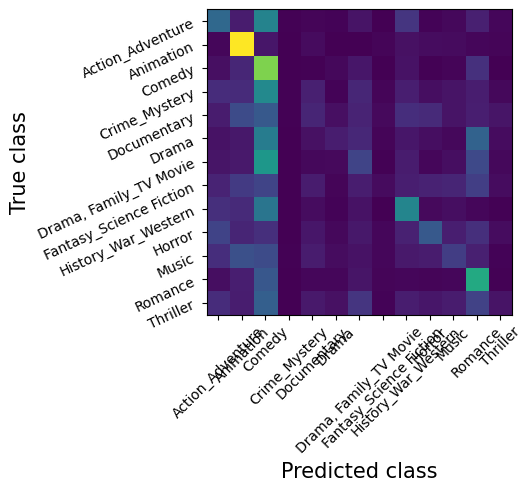

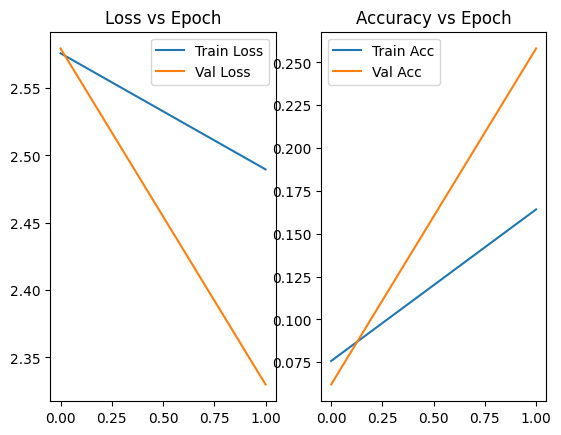

In [13]:
# using  podge_1g_combi_3000 dataset, SeqLR:warmup and cosineannealing, mom=0, weight decay=0
resnet_data, resnet_classes, resnet_preds = model_trainer(lr=0.05, batch_size=128, epochs=2, model_fn=resnet, img_size=224, opti='SGD', momentum=0, weight_decay=0, sched='SequentialLR', save_weights=False)

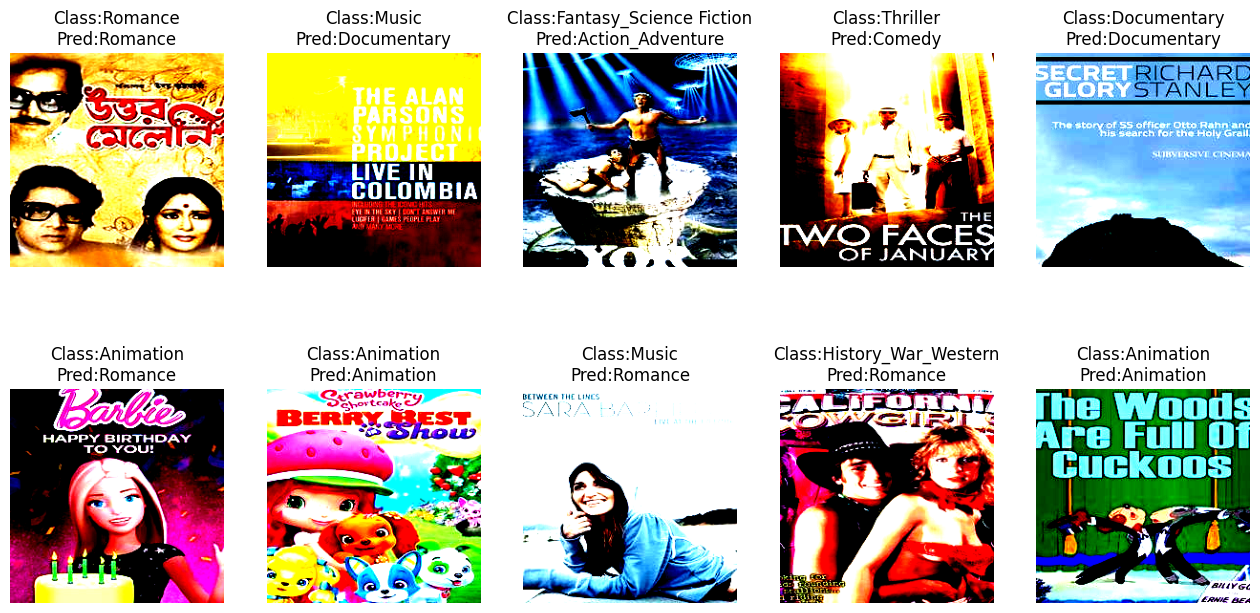

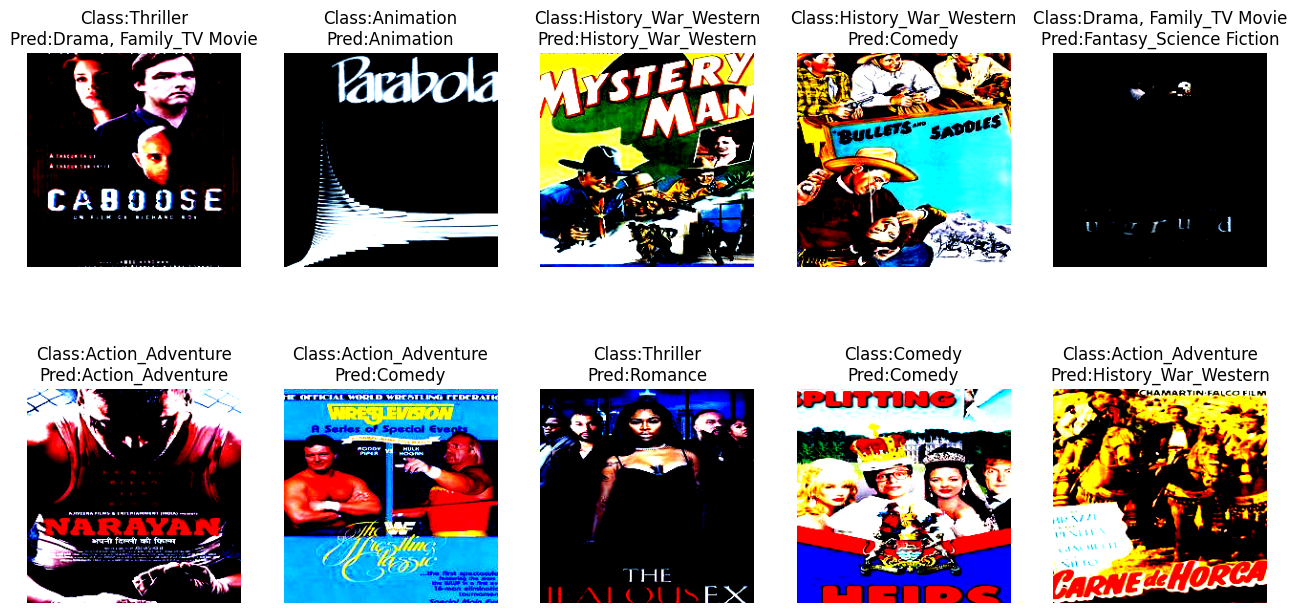

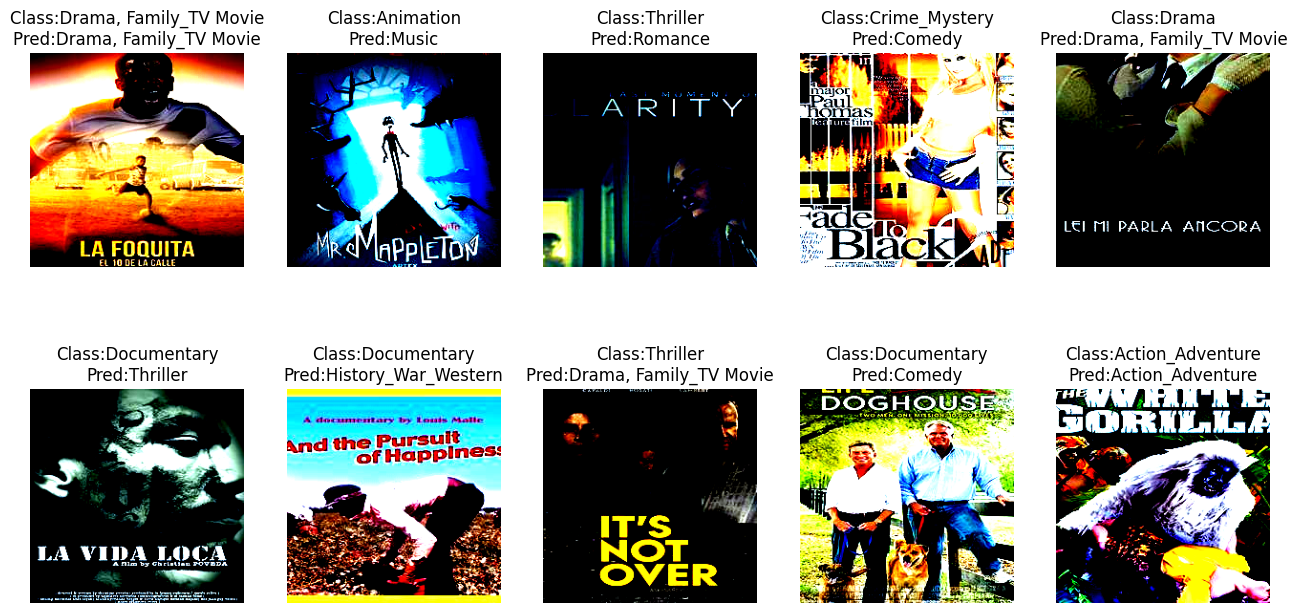

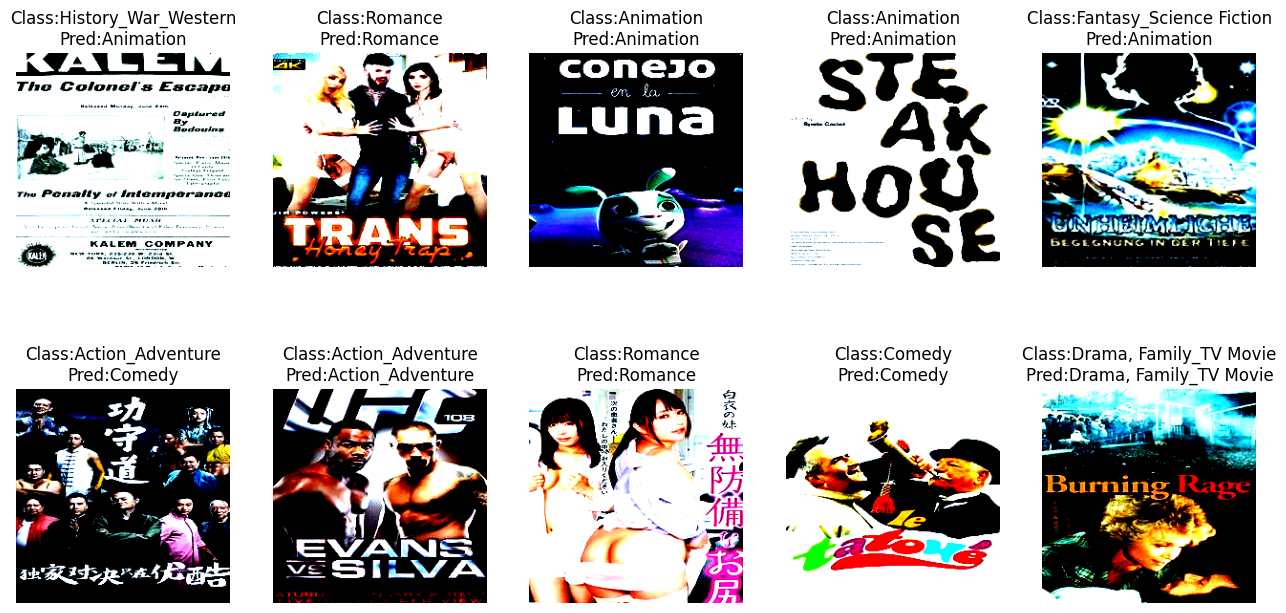

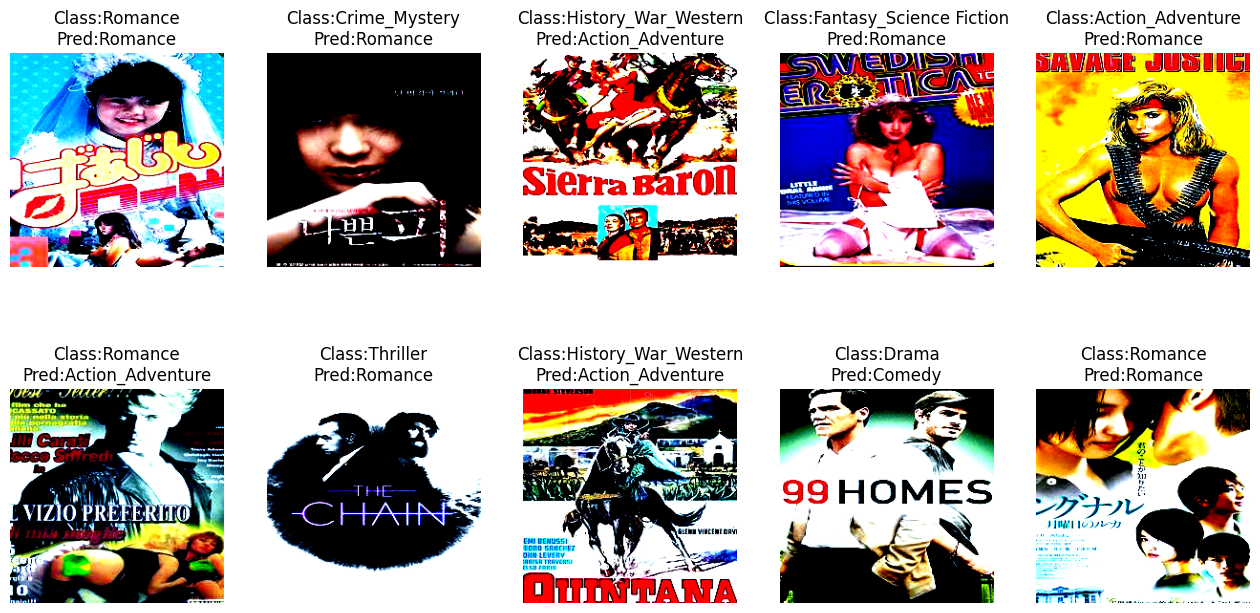

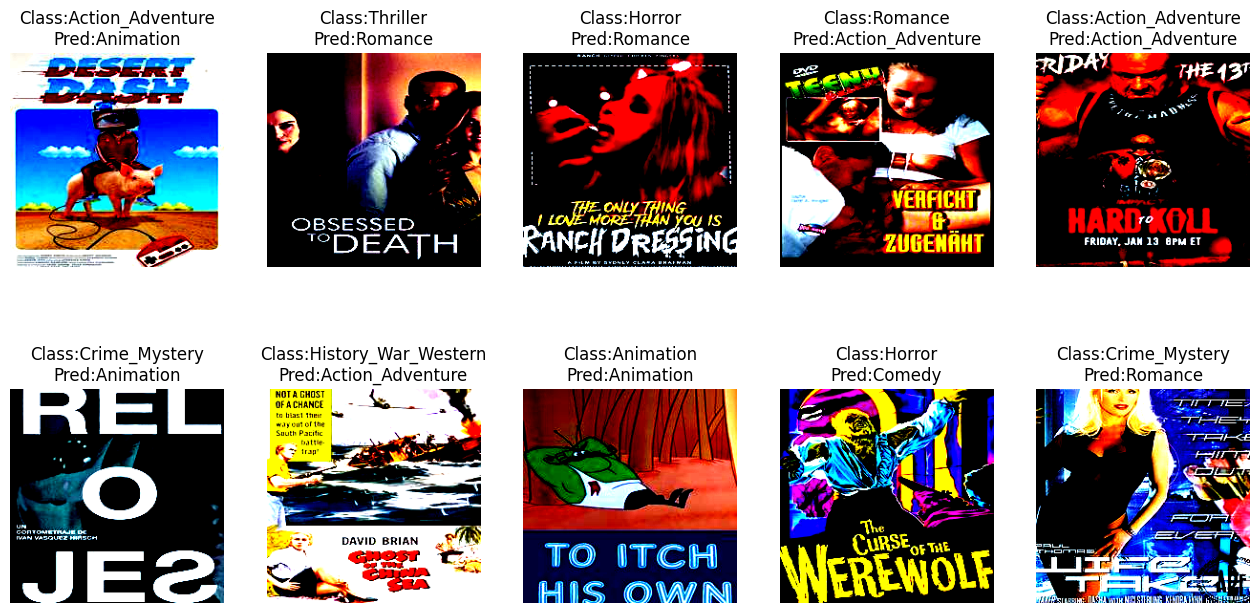

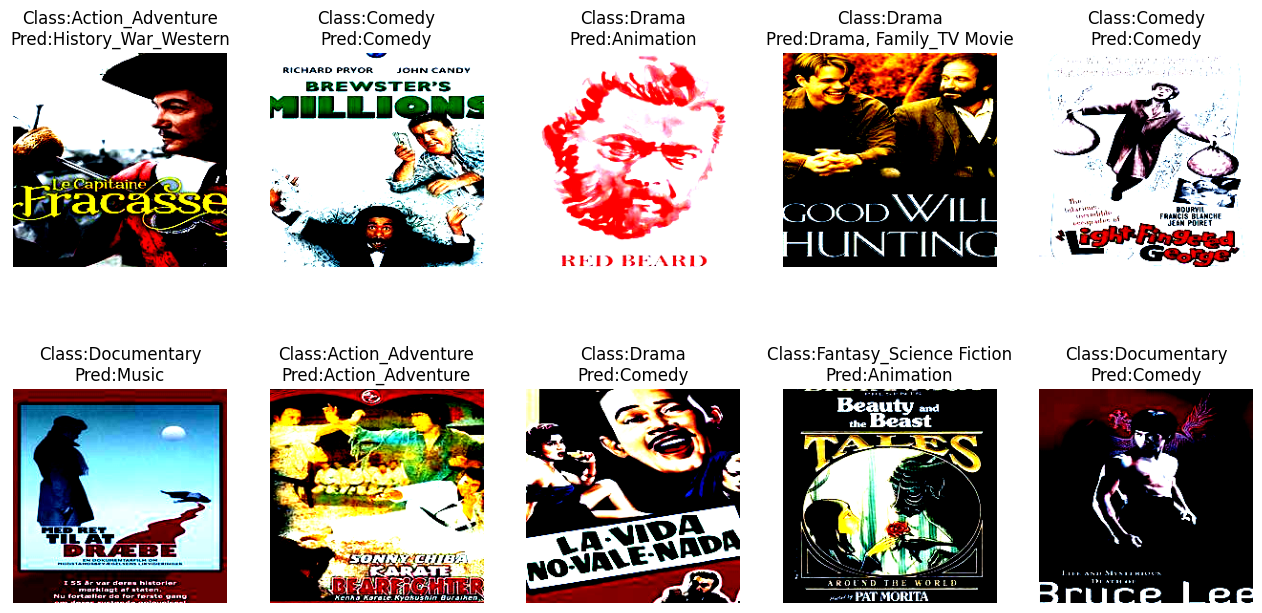

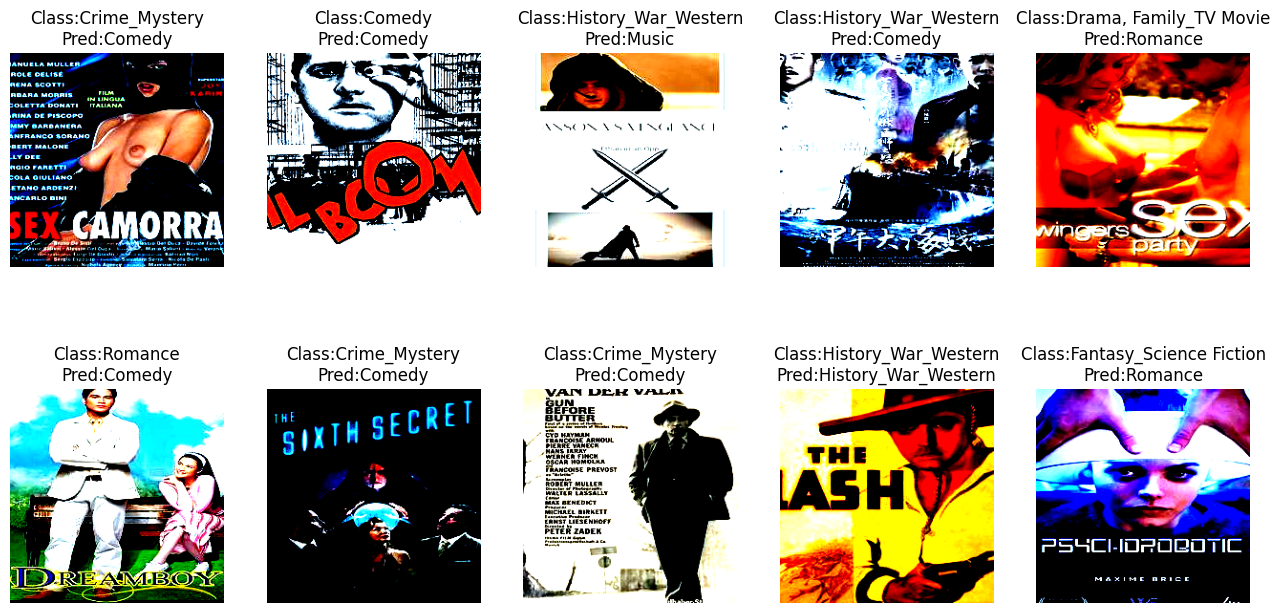

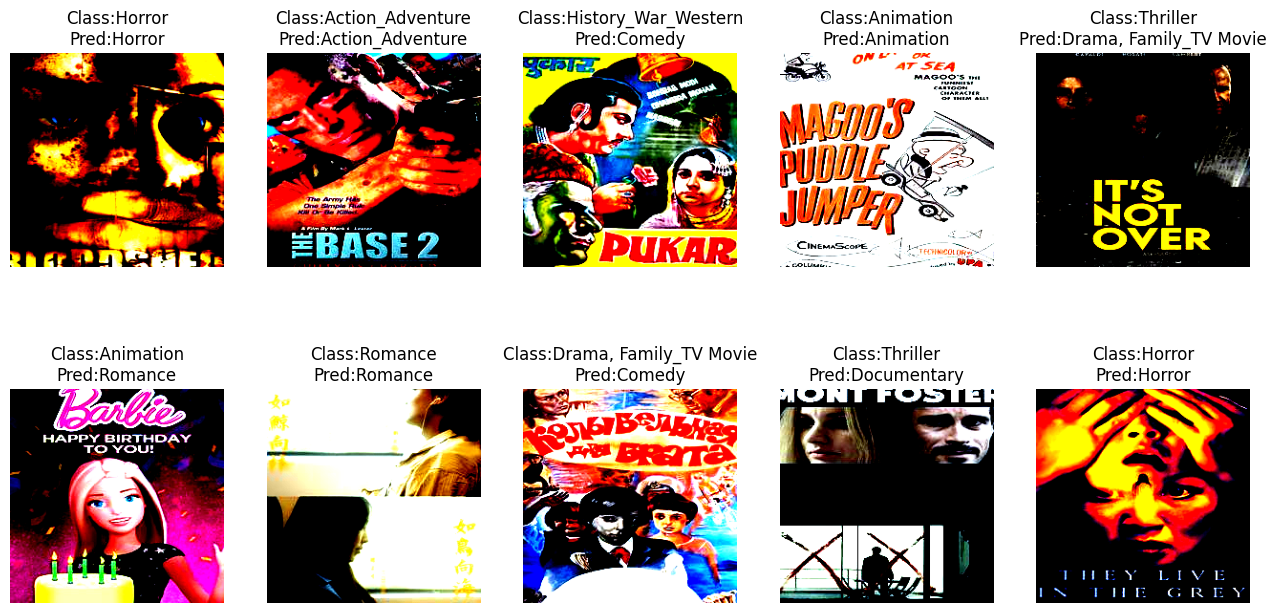

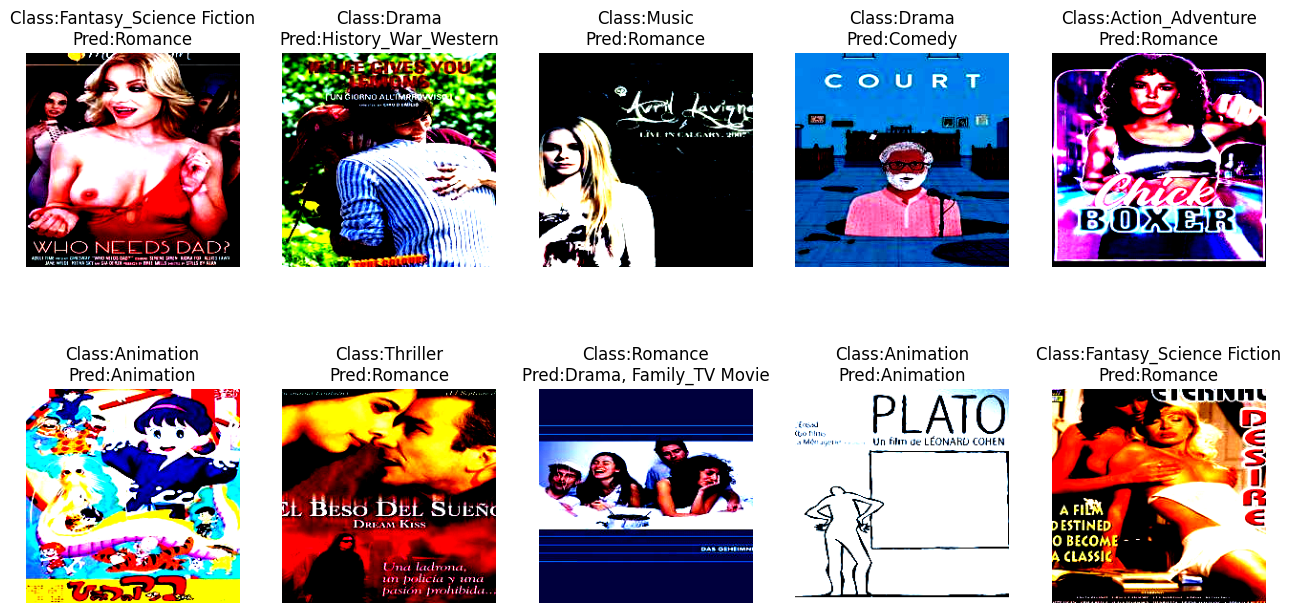

In [14]:
# print random sample of 100 predictions
for i in range(10):
  display_random_images(resnet_data, classes=resnet_classes, preds=resnet_preds, seed=None, display_classes=True)